## Aim
This script is used to balance the dataset and enhance the image quality

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageEnhance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input


In [17]:
import os

# import data
path = '/Users/mayongzhi/Desktop/MSc_Applied_Bioinformatics/AI&ML/Assessment/eye-images/'

normal = os.path.join(path, '1_normal/')
cataract = os.path.join(path, '2_cataract/')
glaucoma = os.path.join(path, '2_glaucoma/')

print("Number of normal images: ", len(os.listdir(normal)))
print("Number of cataract images: ", len(os.listdir(cataract)))
print("Number of glaucoma images: ", len(os.listdir(glaucoma)))

Number of normal images:  300
Number of cataract images:  100
Number of glaucoma images:  101


In [3]:
# Make the image file names into lists
normal_images = os.listdir(normal)
cataract_images = os.listdir(cataract)
glaucoma_images = os.listdir(glaucoma)


## Enhance the image quality
1. Crop the black edges

In [4]:
def crop_black_edges(image_path):
    # STEP 1: Load the image (like opening a microscope slide)
    image = cv2.imread(image_path)
    
    if image is None:
        raise ValueError(f"Could not load image from {image_path}")
    
    # STEP 2: Convert to grayscale (like switching to black & white view)
    if len(image.shape) == 3:  # If image is in color (RGB)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:  # If image is already grayscale
        gray = image
    
    # STEP 3: Blur the image to reduce noise 
    # (like adjusting microscope focus to remove artifacts)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # STEP 4: Create black & white mask 
    # (like setting a brightness threshold - anything darker than 20 becomes black)
    _, thresh = cv2.threshold(blurred, 20, 255, cv2.THRESH_BINARY)
    
    # STEP 5: Clean up the mask (like cleaning your microscope lens)
    kernel = np.ones((5,5), np.uint8)  # Create a small square filter
    # Fill in small holes
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    # Remove small noise
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    
    # STEP 6: Find where the actual eye is (non-black parts)
    coords = cv2.findNonZero(thresh)
    
    # STEP 7: Draw a rectangle around the eye
    x, y, w, h = cv2.boundingRect(coords)
    
    # STEP 8: Add a small border (2 pixels) around the crop
    padding = 2
    x = max(0, x - padding)  # Move left edge left
    y = max(0, y - padding)  # Move top edge up
    w = min(image.shape[1] - x, w + 2*padding)  # Extend width
    h = min(image.shape[0] - y, h + 2*padding)  # Extend height
    
    # STEP 9: Cut out just the eye part
    cropped = image[y:y+h, x:x+w]
    
    # STEP10: Conver to RGB
    cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
    
    return cropped

In [5]:
def plot_images(num_images=10, path = normal, file_name = "normal_images", title = "Normal"):
    plt.figure(figsize=(60, 6))
    for i, image_name in enumerate(file_name[:num_images]):
        img_path = os.path.join(path, image_name)
        img = crop_black_edges(img_path)
        
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(str(title),fontsize =8)
        plt.axis('off')
    plt.show()

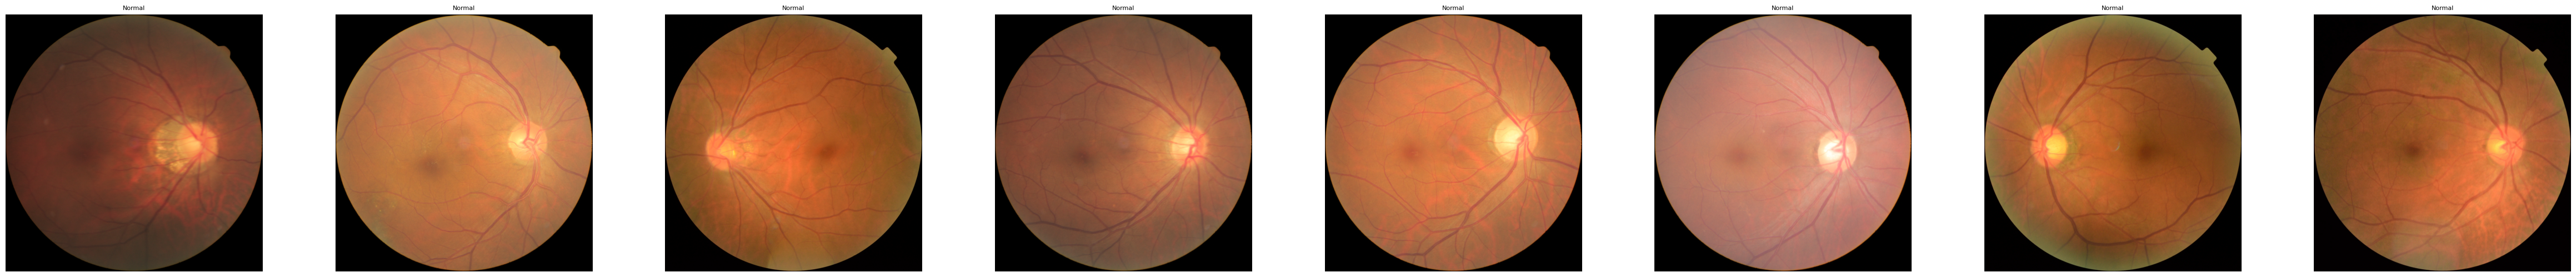

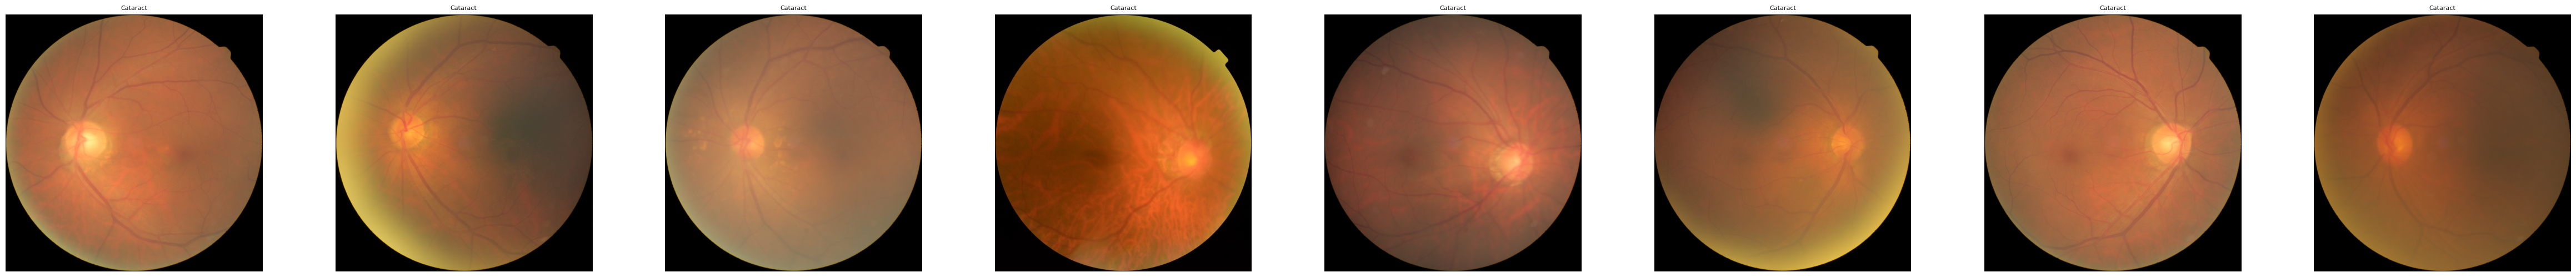

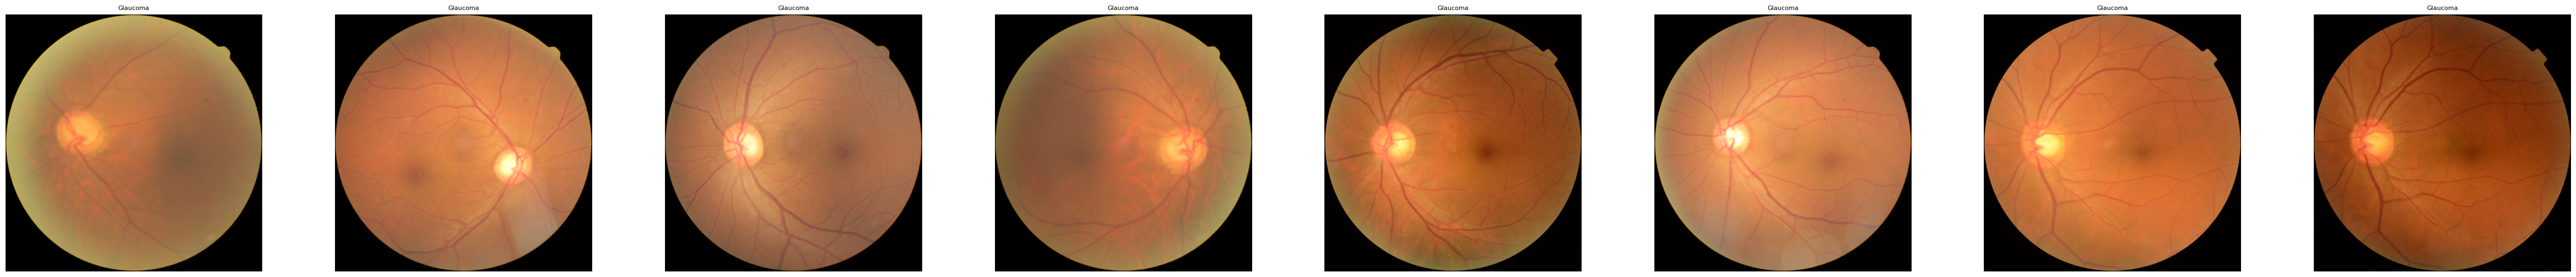

In [6]:
plot_images(num_images=8, path = normal, file_name = normal_images, title = "Normal")
plot_images(num_images=8, path = cataract, file_name = cataract_images, title = "Cataract")
plot_images(num_images=8, path = glaucoma, file_name = glaucoma_images, title = "Glaucoma")

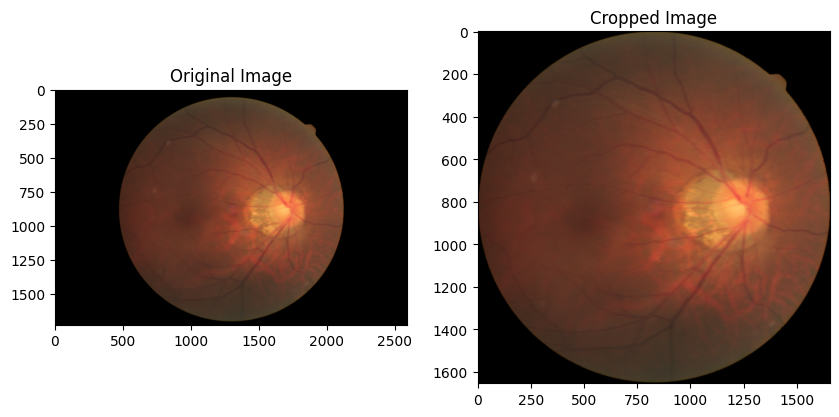

In [7]:
# Plot the original image and the cropped image
image = cv2.cvtColor(cv2.imread(os.path.join(normal, normal_images[0])), cv2.COLOR_BGR2RGB)
cropped_image = crop_black_edges(os.path.join(normal, normal_images[0]))

# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(cropped_image)
plt.title('Cropped Image')
plt.show()

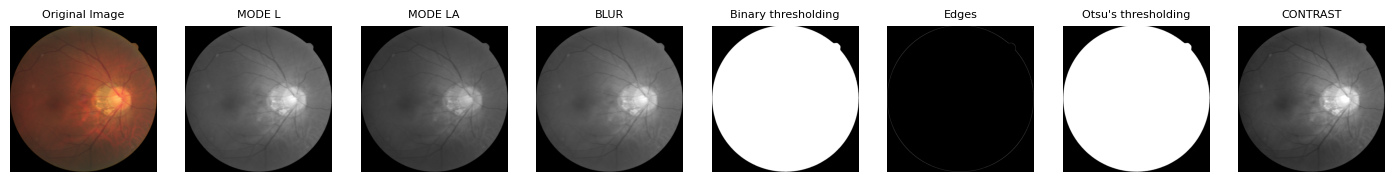

In [80]:
# plot 1 row with 8 images to the row
plt.figure(figsize=(20, 180))
plt.subplot(1, 9, 1)
# plot normal image
plt.imshow(cropped_image)
plt.title(f"Original Image",fontsize =8)
plt.axis('off')

# Convert numpy array to PIL Image for grayscale conversion
pil_image = Image.fromarray(cropped_image)

# Convert to greyscale (mode L)
gray_img = pil_image.convert('L')
gray_img_np = np.array(gray_img)
plt.subplot(1, 9, 2)
plt.imshow(gray_img, cmap='gray')
plt.title(f"MODE L",fontsize=8)
plt.axis('off')

# Grey scale with background
gray_img2 = pil_image.convert('LA')
gray_img2_np = np.array(gray_img2)
plt.subplot(1, 9, 3)
plt.imshow(gray_img2, cmap='gray')
plt.title(f"MODE LA",fontsize=8)
plt.axis('off')

# blur with a 5x5 kernel
plt.subplot(1, 9, 4)
gray_img_np = np.array(gray_img)
blur_img = cv2.GaussianBlur(gray_img_np, (5, 5), 0)
plt.imshow(blur_img, cmap='gray')
plt.title(f"BLUR",fontsize =8)
plt.axis('off')

# binary thresholding
_, thresh_img = cv2.threshold(gray_img_np, 35, 255, cv2.THRESH_BINARY)
plt.subplot(1,9,5)
plt.imshow(thresh_img, cmap='gray')
plt.title("Binary thresholding", fontsize=8)
plt.axis('off')

# Adjust contrast using PIL ImageENhance
plt.subplot(1, 9, 8)
enhancer = ImageEnhance.Contrast(gray_img)
contrast_img = enhancer.enhance(1.5)
contrast_img_np = np.array(contrast_img)
plt.imshow(contrast_img_np, cmap='gray')
plt.title(f"CONTRAST",fontsize =8)
plt.axis('off')

# edge detection (Canny)
edges = cv2.Canny(contrast_img_np, 100, 200) # Run the cell start with Pillow Library below
plt.subplot(1, 9, 6)
plt.imshow(edges, cmap='gray')
plt.title(f"Edges",fontsize =8)
plt.axis('off')

# Otsu's thresholding
_, segmented_img = cv2.threshold(gray_img_np, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.subplot(1, 9, 7)
plt.imshow(segmented_img, cmap='gray')
plt.title("Otsu's thresholding", fontsize=8)
plt.axis('off')


plt.show()

In [15]:
def preprocess_image(image_path):
    """
    Combined function to process images:
    1. Crop black edges
    2. Convert to grayscale
    3. Resize to consistent dimensions
    4. Normalize pixel values
    
    Args:
        image_path: Path to the image file
    Returns:
        Processed image as numpy array
    """
    try:
        # Crop black edges
        cropped = crop_black_edges(image_path)
        
        # Convert to grayscale
        if len(cropped.shape) == 3:
            gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
        else:
            gray = cropped
            
        # Resize to consistent dimensions (100x100)
        resized = cv2.resize(gray, (100, 100))
        
        # Normalize pixel values to 0-1
        normalized = resized / 255.0
        
        return normalized
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None


In [23]:
def load_images(directories, n_images=900000):
    """
    Load and preprocess images from multiple directories
    
    Args:
        directories: List of directory paths containing images
        n_images: Maximum number of images to load per class
    Returns:
        images: Numpy array of processed images
        labels: Numpy array of corresponding labels
    """
    images = []
    labels = []
    
    for label, directory in enumerate(directories):
        class_name = os.path.basename(directory)  # Get directory name
        print(f"\nProcessing {class_name} class ({label + 1}/{len(directories)})")
        
        files = os.listdir(directory)[:n_images]
        print(f"Loading {len(files)} images from {len(os.listdir(directory))} total images")
        
        for i, file_name in enumerate(files):
            print(f"Processing image {i + 1}/{n_images} from {class_name}")
            img_path = os.path.join(directory, file_name)
            processed_img = preprocess_image(img_path)
            
            if processed_img is not None:
                images.append(processed_img)
                labels.append(label)
    
    return np.array(images), np.array(labels)

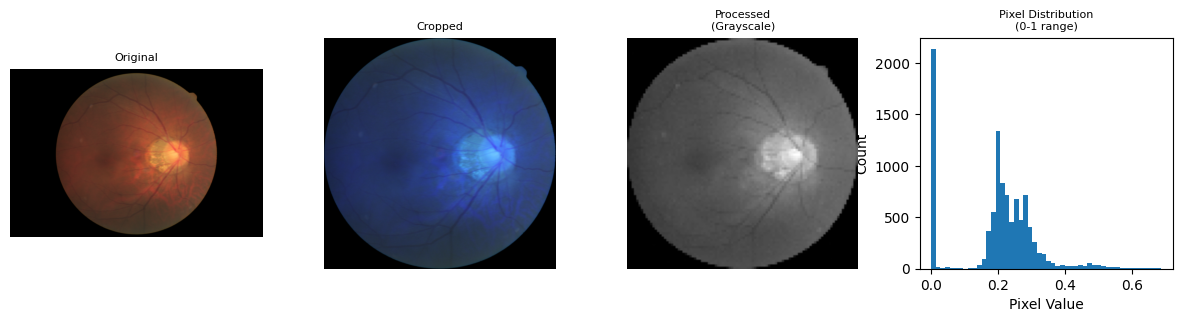


Testing load_images function...

Processing  class (1/3)
Loading 5 images from 300 total images
Processing image 1/5 from 
Processing image 2/5 from 
Processing image 3/5 from 
Processing image 4/5 from 
Processing image 5/5 from 

Processing  class (2/3)
Loading 5 images from 100 total images
Processing image 1/5 from 
Processing image 2/5 from 
Processing image 3/5 from 
Processing image 4/5 from 
Processing image 5/5 from 

Processing  class (3/3)
Loading 5 images from 101 total images
Processing image 1/5 from 
Processing image 2/5 from 
Processing image 3/5 from 
Processing image 4/5 from 
Processing image 5/5 from 

Loaded 15 images
Image shape: (100, 100)
Pixel value range: 0.000 to 0.686


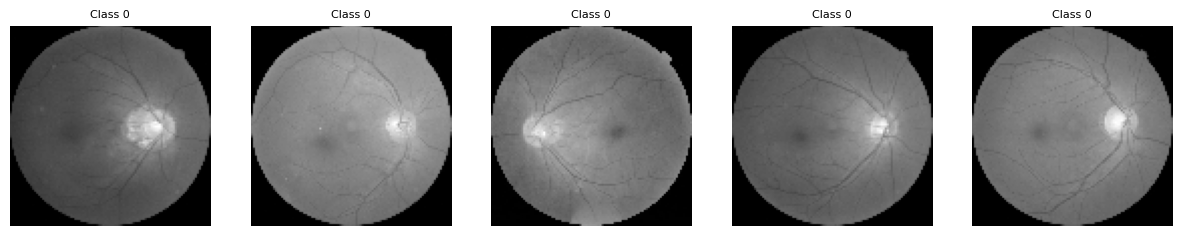

In [24]:
# Test the functions
def test_preprocessing():
    """
    Test preprocessing on a single image
    """
    # Test with one image from normal directory
    test_files = os.listdir(normal)
    if test_files:
        test_image_path = os.path.join(normal, test_files[0])
            
        # Show preprocessing steps
        plt.figure(figsize=(15, 3))
        
        # Original
        original = cv2.imread(test_image_path)
        plt.subplot(1, 4, 1)
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title('Original', fontsize=8)
        plt.axis('off')
        
        # After cropping
        cropped = crop_black_edges(test_image_path)
        plt.subplot(1, 4, 2)
        plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        plt.title('Cropped', fontsize=8)
        plt.axis('off')
        
        # After full preprocessing
        processed = preprocess_image(test_image_path)
        plt.subplot(1, 4, 3)
        plt.imshow(processed, cmap='gray')
        plt.title('Processed\n(Grayscale)', fontsize=8)
        plt.axis('off')
        
        # Show pixel value range
        plt.subplot(1, 4, 4)
        plt.hist(processed.ravel(), bins=50)
        plt.title('Pixel Distribution\n(0-1 range)', fontsize=8)
        plt.xlabel('Pixel Value')
        plt.ylabel('Count')
        
        plt.show()
        
        # Test loading multiple images
        print("\nTesting load_images function...")
        images, labels = load_images([normal, cataract, glaucoma], n_images=5)
        print(f"\nLoaded {len(images)} images")
        print(f"Image shape: {images[0].shape}")
        print(f"Pixel value range: {images[0].min():.3f} to {images[0].max():.3f}")
        
        # Show sample of loaded images
        plt.figure(figsize=(15, 3))
        for i in range(min(5, len(images))):
            plt.subplot(1, 5, i+1)
            plt.imshow(images[i], cmap='gray')
            plt.title(f'Class {labels[i]}', fontsize=8)
            plt.axis('off')

        plt.show()
    else:
        print("No test files found in normal directory")

# Run the test
test_preprocessing()

In [25]:
images, labels = load_images([normal, cataract, glaucoma])


Processing  class (1/3)
Loading 300 images from 300 total images
Processing image 1/900000 from 
Processing image 2/900000 from 
Processing image 3/900000 from 
Processing image 4/900000 from 
Processing image 5/900000 from 
Processing image 6/900000 from 
Processing image 7/900000 from 
Processing image 8/900000 from 
Processing image 9/900000 from 
Processing image 10/900000 from 
Processing image 11/900000 from 
Processing image 12/900000 from 
Processing image 13/900000 from 
Processing image 14/900000 from 
Processing image 15/900000 from 
Processing image 16/900000 from 
Processing image 17/900000 from 
Processing image 18/900000 from 
Processing image 19/900000 from 
Processing image 20/900000 from 
Processing image 21/900000 from 
Processing image 22/900000 from 
Processing image 23/900000 from 
Processing image 24/900000 from 
Processing image 25/900000 from 
Processing image 26/900000 from 
Processing image 27/900000 from 
Processing image 28/900000 from 
Processing image 29


Displaying 5 random images from each class:


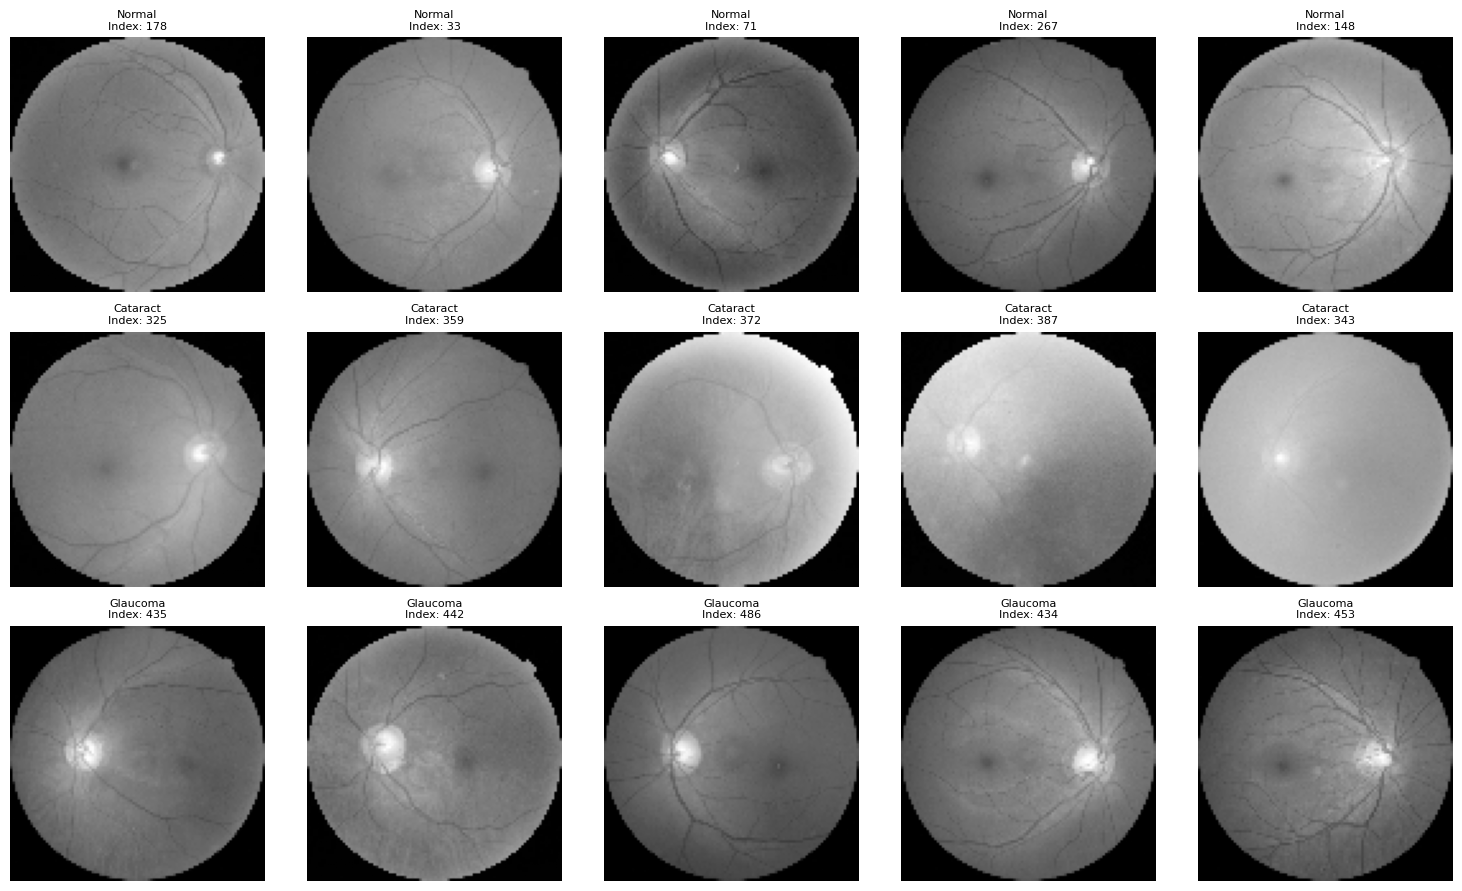

In [34]:
# Select random images from specific classes to check
def display_random_per_class(images, labels, n_per_class=5, class_names=['Normal', 'Cataract', 'Glaucoma']):
    """
    Display equal number of random images from each class
    """
    plt.figure(figsize=(15, 3*len(class_names)))
    
    for class_id in range(len(class_names)):
        # Get indices for this class
        class_indices = np.where(labels == class_id)[0]
        
        # Randomly select n_per_class images
        selected_indices = np.random.choice(class_indices, n_per_class, replace=False)
        
        # Display images for this class
        for i, idx in enumerate(selected_indices):
            plt.subplot(len(class_names), n_per_class, class_id*n_per_class + i + 1)
            plt.imshow(images[idx], cmap='gray')
            plt.title(f'{class_names[class_id]}\nIndex: {idx}', fontsize=8)
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display 5 random images from each class
print("\nDisplaying 5 random images from each class:")
display_random_per_class(images, labels, n_per_class=5)

In [41]:
def balance_by_augmentation(directories, names=['Normal', 'Cataract', 'Glaucoma']):
    """
    Balance dataset by augmenting classes with fewer samples until they match the largest class.
    
    Args:
        directories: List of directory paths containing images
        names: List of class names corresponding to directories
    Returns:
        balanced_images: Numpy array of balanced dataset
        balanced_labels: Numpy array of corresponding labels
    """
    # Find largest class size
    max_size = max(len(os.listdir(dir)) for dir in directories)
    
    # Create augmentation generator
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    balanced_images = []
    balanced_labels = []
    
    for label, (dir, name) in enumerate(zip(directories, names)):
        files = os.listdir(dir)
        current_size = len(files)
        print(f"\nProcessing {name} class: {current_size} original images")
        
        # Original images
        for file in files:
            img_path = os.path.join(dir, file)
            img = preprocess_image(img_path)  # Using existing preprocess_image function
            if img is not None:  # Check if image was processed successfully
                balanced_images.append(img)
                balanced_labels.append(label)
        
        # Generate augmented images if needed
        if current_size < max_size:
            num_to_generate = max_size - current_size
            print(f"Generating {num_to_generate} additional images for {name}")
            
            # Reshape for augmentation (add channel dimension)
            imgs_to_augment = np.array(balanced_images[-current_size:])
            imgs_to_augment = imgs_to_augment.reshape((-1, 100, 100, 1))
            
            # Generate augmented images
            aug_iter = datagen.flow(imgs_to_augment, batch_size=1)
            for i in range(num_to_generate):
                aug_img = next(aug_iter)[0]
                balanced_images.append(aug_img.reshape(100, 100))
                balanced_labels.append(label)
                if (i + 1) % 100 == 0:  # Progress update every 100 images
                    print(f"Generated {i + 1}/{num_to_generate} augmented images")
        
        print(f"{name}: {max_size} images after balancing")
    
    return np.array(balanced_images), np.array(balanced_labels)

In [42]:
balanced_images, balanced_labels = balance_by_augmentation([normal, cataract, glaucoma])


Processing Normal class: 300 original images
Normal: 300 images after balancing

Processing Cataract class: 100 original images
Generating 200 additional images for Cataract
Generated 100/200 augmented images
Generated 200/200 augmented images
Cataract: 300 images after balancing

Processing Glaucoma class: 101 original images
Generating 199 additional images for Glaucoma
Generated 100/199 augmented images
Glaucoma: 300 images after balancing


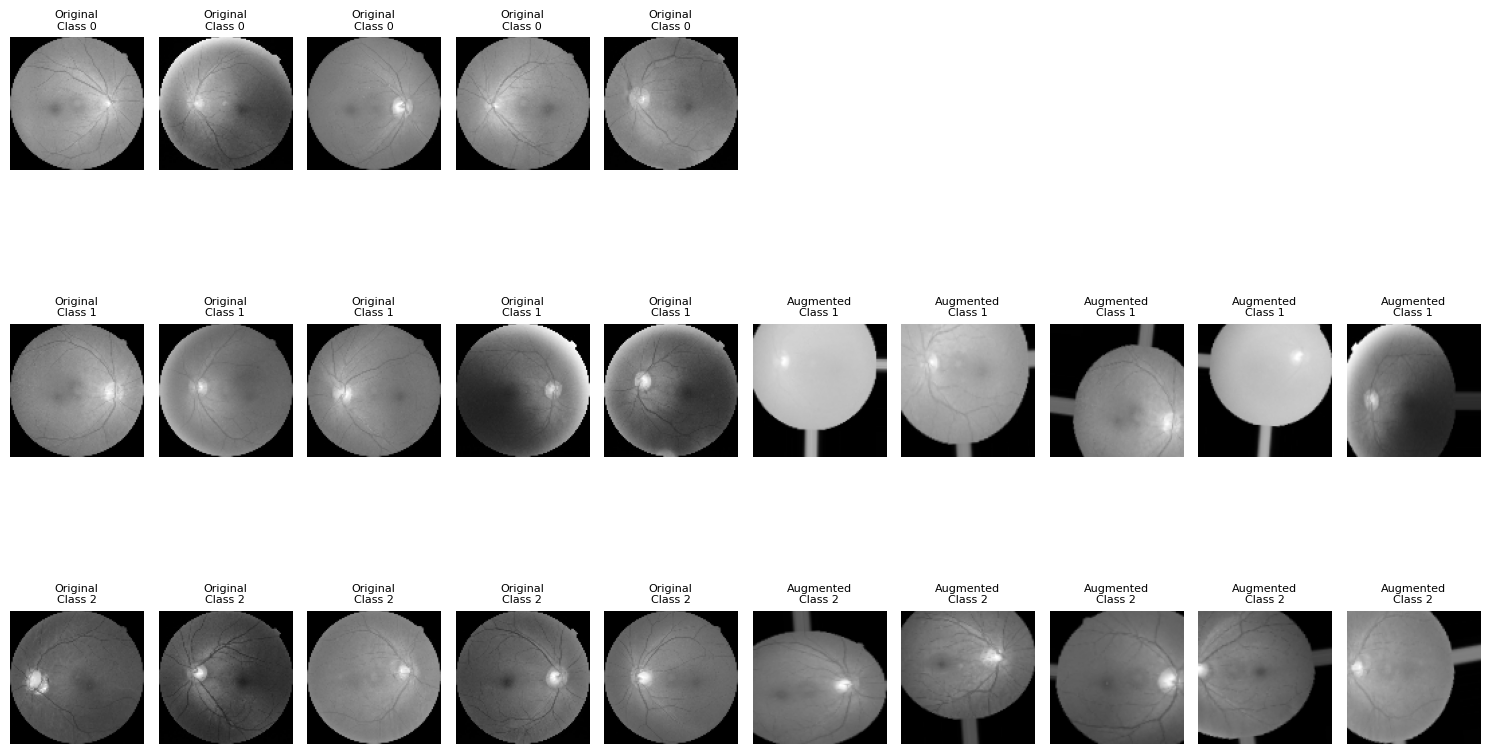

In [43]:
def display_augmented_samples(balanced_images, balanced_labels, original_sizes, n_samples=5):
    """
    Display random samples of original and augmented images for each class.
    
    Args:
        balanced_images: Array of all images (original + augmented)
        balanced_labels: Array of corresponding labels
        original_sizes: Dictionary mapping class indices to their original sizes
        n_samples: Number of samples to display per class (default=5)
    """
    unique_labels = np.unique(balanced_labels)
    n_classes = len(unique_labels)
    
    plt.figure(figsize=(15, 3*n_classes))
    
    for label in unique_labels:
        # Get indices for this class
        class_indices = np.where(balanced_labels == label)[0]
        original_size = len(os.listdir([normal, cataract, glaucoma][label]))
        
        # Get random original samples
        original_indices = np.random.choice(class_indices[:original_size], 
                                         min(n_samples, original_size), 
                                         replace=False)
        
        # Get random augmented samples
        if len(class_indices) > original_size:
            augmented_indices = np.random.choice(class_indices[original_size:], 
                                              n_samples, 
                                              replace=False)
        else:
            augmented_indices = []
        
        # Plot original samples
        for i, idx in enumerate(original_indices):
            plt.subplot(n_classes, n_samples*2, label*n_samples*2 + i + 1)
            plt.imshow(balanced_images[idx], cmap='gray')
            plt.title(f'Original\nClass {label}', fontsize=8)
            plt.axis('off')
        
        # Plot augmented samples
        for i, idx in enumerate(augmented_indices):
            plt.subplot(n_classes, n_samples*2, label*n_samples*2 + n_samples + i + 1)
            plt.imshow(balanced_images[idx], cmap='gray')
            plt.title(f'Augmented\nClass {label}', fontsize=8)
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Use the function
# First, get original sizes
original_sizes = {
    0: len(os.listdir(normal)),
    1: len(os.listdir(cataract)),
    2: len(os.listdir(glaucoma))
}

# Display samples
display_augmented_samples(balanced_images, balanced_labels, original_sizes, n_samples=5)

## Model Training
Train with a neural network model

In [44]:
# Split the data into training and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(balanced_images, balanced_labels, test_size=0.2, random_state=42)

In [45]:
# Build an NN model
model = Sequential([
  Input(shape=(100,100)),   # The image is 100x100 pixels.
  Flatten(),
  Dense(units=4048, activation='relu'),
  Dense(units=2048, activation='relu'),  # Increased dense layer size
  Dense(units=1024, activation='relu'),  # Increased dense layer size
  Dense(units=512, activation='relu'),  # Increased dense layer size                                      
  Dense(units=256, activation='relu'),  # Increased dense layer size
  Dense(units=128, activation='relu'),  # Increased dense layer size
  Dense(units=64, activation='relu'),  # Increased dense layer size
  Dense(units=32, activation='relu'),  # Increased dense layer size
  Dense(3, activation='softmax')  # Two state classification - gives probability of belonging to class 0 or 1
])


In [46]:
model.compile(optimizer=Adam(learning_rate= 0.003),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy', 'categorical_accuracy'])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4048)           │    40,484,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     8,292,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,574,035 (196.74 MB)

 Trainable params: 51,574,035 (196.74 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
history = model.fit(x=X_train, y=y_train, batch_size=50,
                      epochs=20, shuffle=True,
                      validation_split=0.2)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 384ms/step - accuracy: 0.3070 - categorical_accuracy: 0.5291 - loss: 1.2027 - val_accuracy: 0.3542 - val_categorical_accuracy: 1.0000 - val_loss: 1.2027
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 411ms/step - accuracy: 0.3327 - categorical_accuracy: 0.3310 - loss: 1.1340 - val_accuracy: 0.3542 - val_categorical_accuracy: 0.9861 - val_loss: 1.0789
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 389ms/step - accuracy: 0.3691 - categorical_accuracy: 0.2448 - loss: 1.0871 - val_accuracy: 0.5208 - val_categorical_accuracy: 0.6319 - val_loss: 0.9743
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 387ms/step - accuracy: 0.5377 - categorical_accuracy: 0.2575 - loss: 1.0211 - val_accuracy: 0.5139 - val_categorical_accuracy: 0.6597 - val_loss: 1.0107
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 387ms/step - accuracy: 0.5456 - categorical_accuracy: 0.2011 - loss: 0.9383 - val_accuracy: 0.5903 - val_categorical_accuracy: 0.5486 - val_loss: 0.8613
Epoch 6/20
12/12 ━━━━━━━━━━━━━

In [59]:
epochs = history.epoch
hist = pd.DataFrame(history.history)
hist

accuracy  categorical_accuracy      loss  val_accuracy  \
0   0.314236              0.402778  1.207781      0.354167   
1   0.340278              0.173611  1.129056      0.354167   
2   0.397569              0.215278  1.065697      0.520833   
3   0.552083              0.241319  1.001743      0.513889   
4   0.541667              0.246528  0.922046      0.590278   
5   0.541667              0.371528  0.911936      0.562500   
6   0.585069              0.265625  0.912202      0.604167   
7   0.569444              0.204861  0.899395      0.555556   
8   0.588542              0.163194  0.873003      0.395833   
9   0.508681              0.307292  0.958507      0.520833   
10  0.555556              0.348958  0.888256      0.534722   
11  0.576389              0.166667  0.864345      0.548611   
12  0.586806              0.248264  0.851953      0.555556   
13  0.576389              0.282986  0.851527      0.548611   
14  0.585069              0.239583  0.855528      0.604167   
15  0.598958              0.407986  0.834818      0.576389   
16  0.605903              0.340278  0.832444      0.555556   
17  0.565972              0.251736  0.853748      0.604167   
18  0.595486              0.137153  0.837580      0.555556   
19  0.600694              0.352431  0.835471      0.583333   

    val_categorical_accuracy  val_loss  
0                   1.000000  1.202654  
1                   0.986111  1.078861  
2                   0.631944  0.974283  
3                   0.659722  1.010691  
4                   0.548611  0.861306  
5                   0.548611  0.916258  
6                   0.548611  0.928416  
7                   0.555556  0.963396  
8                   0.187500  1.110418  
9                   0.604167  0.979226  
10                  0.548611  0.864431  
11                  0.548611  0.871389  
12                  0.548611  0.838031  
13                  0.555556  0.837031  
14                  0.548611  0.838662  
15                  0.548611  0.866289  
16                  0.548611  0.858992  
17                  0.548611  0.842059  
18                  0.548611  0.895957  
19                  0.548611  0.847263

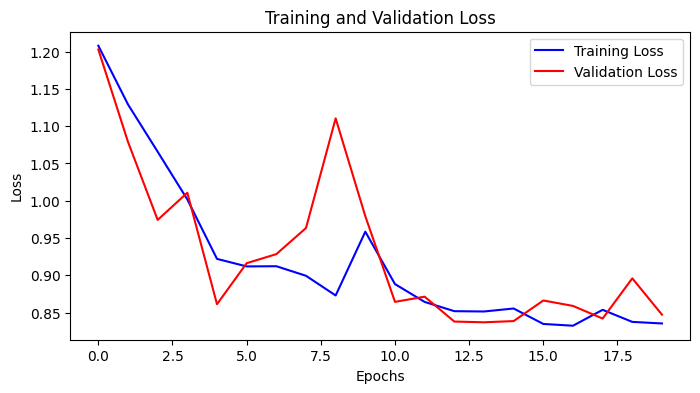

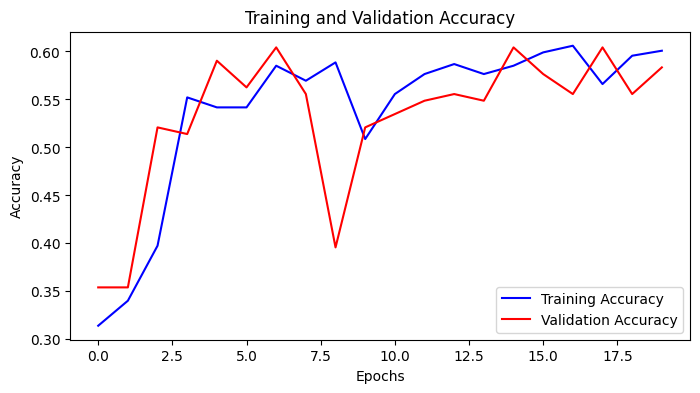

In [61]:
epochs = history.epoch
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

accuracy_values = history.history['accuracy']
val_accuracy_values = history.history['val_accuracy']

plt.figure(figsize=(8, 4))
plt.plot(epochs, loss_values, 'b', label='Training Loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(epochs, accuracy_values, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Problems in this model:
1. Oververfitting Pattern: The validation accuracy (red line) initially improves but shows fluctuations or even starts to decline after a certain point (around 10–15 epochs). This indicates overfitting: the model is learning the training data too well but failing to generalize to unseen validation data.
2. Instability in valadation accuracy: The validation accuracy fluctuates significantly, suggesting that the model might be sensitive to the validation dataset, or there might be issues with the data distribution, insufficient regularization, or hyperparameter choices.
3. Performance Plateau: After a few epochs (around 5–7 epochs), the training accuracy plateaus, but the validation accuracy does not show consistent improvement. This might indicate that the model has reached its learning capacity for the given data or architecture.
4. High Loss: The loss values (both training and validation) are relatively high, indicating that the model is not performing well. This suggests that the model is not able to learn the underlying patterns in the data effectively.
5. Low Accuracy: The overall accuracy of the model is low, indicating that the model is not able to correctly classify the majority of the test data. This suggests that the model is not able to generalize well to unseen data.

In [62]:
# Use the model to make predictions on the testset
y_pred_prob = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [63]:
y_pred_prob[0:20]

array([[5.2364063e-01, 2.2003987e-01, 2.5631946e-01],
       [3.9153796e-04, 4.3584356e-01, 5.6376493e-01],
       [5.6138819e-01, 2.1742901e-01, 2.2118278e-01],
       [2.6827996e-05, 7.5336623e-01, 2.4660695e-01],
       [5.5440980e-01, 2.1742330e-01, 2.2816686e-01],
       [2.2822304e-03, 4.0868735e-01, 5.8903044e-01],
       [5.2814209e-01, 2.1777400e-01, 2.5408384e-01],
       [5.2163398e-01, 2.1863262e-01, 2.5973335e-01],
       [5.3508341e-01, 2.1692160e-01, 2.4799502e-01],
       [5.8390695e-01, 2.1466427e-01, 2.0142877e-01],
       [5.5211627e-01, 2.1656319e-01, 2.3132056e-01],
       [3.8378226e-04, 6.5652901e-01, 3.4308711e-01],
       [1.8560720e-05, 7.9863816e-01, 2.0134331e-01],
       [5.2180356e-01, 2.1980385e-01, 2.5839260e-01],
       [1.7891217e-03, 5.5601341e-01, 4.4219747e-01],
       [2.1369664e-04, 5.4011965e-01, 4.5966661e-01],
       [5.7419944e-01, 2.1540405e-01, 2.1039648e-01],
       [1.4083205e-03, 5.7672900e-01, 4.2186278e-01],
       [5.2166582e-05, 3.719

In [64]:
y_pred = y_pred_prob.argmax(axis=1)
y_pred


array([0, 2, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 2, 0, 0, 1,
       0, 0, 2, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 2, 0, 1, 1, 0, 0, 2, 0, 2, 0, 0, 1, 0, 1, 0, 1, 2, 0, 2,
       0, 1, 0, 1, 2, 1, 2, 0, 0, 0, 0, 1, 1, 1, 2, 0, 1, 0, 0, 0, 2, 0,
       2, 1, 2, 1, 2, 2, 1, 2, 0, 2, 0, 0, 0, 2, 1, 0, 0, 1, 1, 0, 2, 1,
       0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 2, 2,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 2, 1, 0, 0, 0, 1, 1, 2,
       2, 2, 0, 0])

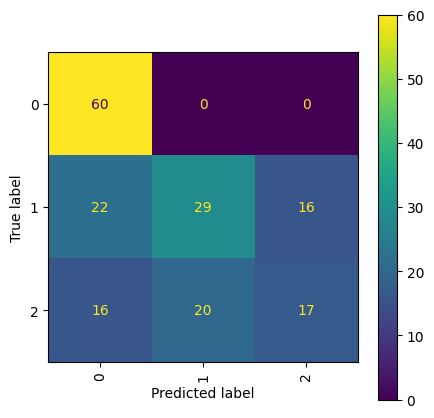

In [65]:
cm  = confusion_matrix(y_test, y_pred)
cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(5, 5))
cmdisp.plot(include_values=True, cmap="viridis", ax=ax, xticks_rotation="vertical")
plt.show()

In [66]:
print('Classification Report:')
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.61      1.00      0.76        60
           1       0.59      0.43      0.50        67
           2       0.52      0.32      0.40        53

    accuracy                           0.59       180
   macro avg       0.57      0.58      0.55       180
weighted avg       0.58      0.59      0.56       180



## Model 2: CNN & Data Augmentation while training


In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, 
    Flatten, 
    Dropout, 
    Input, 
    Conv2D, 
    MaxPooling2D, 
    BatchNormalization,
    Reshape
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [84]:
# Current architecture with improvements
# Reshape the data
X_train_reshaped = X_train.reshape(-1, 50, 50, 1)
X_test_reshaped = X_test.reshape(-1, 50, 50, 1)


model = Sequential([
    Input(shape=(100, 100)),
    Reshape((100, 100, 1)),  # Add channel dimension
    
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Improved compilation settings
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Add early stopping

In [85]:
# Add callbacks for better training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
]

# Modified training
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,  # Increase epochs since we have early stopping
    batch_size=32,  # Modified batch size
    callbacks=callbacks,
    shuffle=True
)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 500ms/step - accuracy: 0.3849 - loss: 1.8664 - val_accuracy: 0.3542 - val_loss: 1.1136 - learning_rate: 1.0000e-04
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 677ms/step - accuracy: 0.4873 - loss: 1.4967 - val_accuracy: 0.3611 - val_loss: 1.0956 - learning_rate: 1.0000e-04
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 702ms/step - accuracy: 0.5416 - loss: 1.3081 - val_accuracy: 0.3542 - val_loss: 1.1456 - learning_rate: 1.0000e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 634ms/step - accuracy: 0.5268 - loss: 1.3682 - val_accuracy: 0.3542 - val_loss: 1.1690 - learning_rate: 1.0000e-04
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 625ms/step - accuracy: 0.5466 - loss: 1.2459 - val_accuracy: 0.3542 - val_loss: 1.2025 - learning_rate: 1.0000e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 593ms/step - accuracy: 0.5980 - loss: 1.1951 - val_accuracy: 0.3542 - val_loss: 1.3035 - learning_rate: 1.0000e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 555ms/ste

Add data augmentation during training

Add model evaluation function


In [77]:
import seaborn as sns

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step


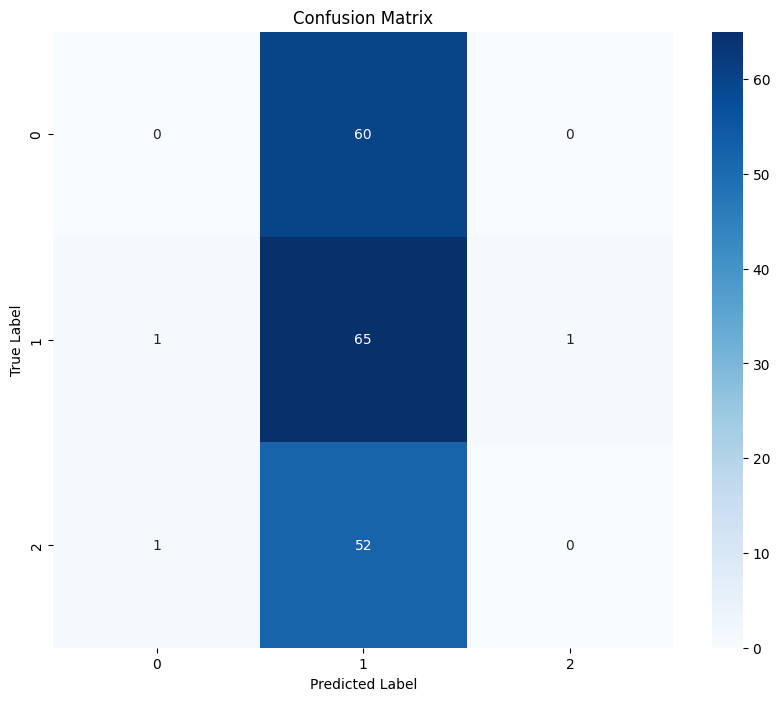

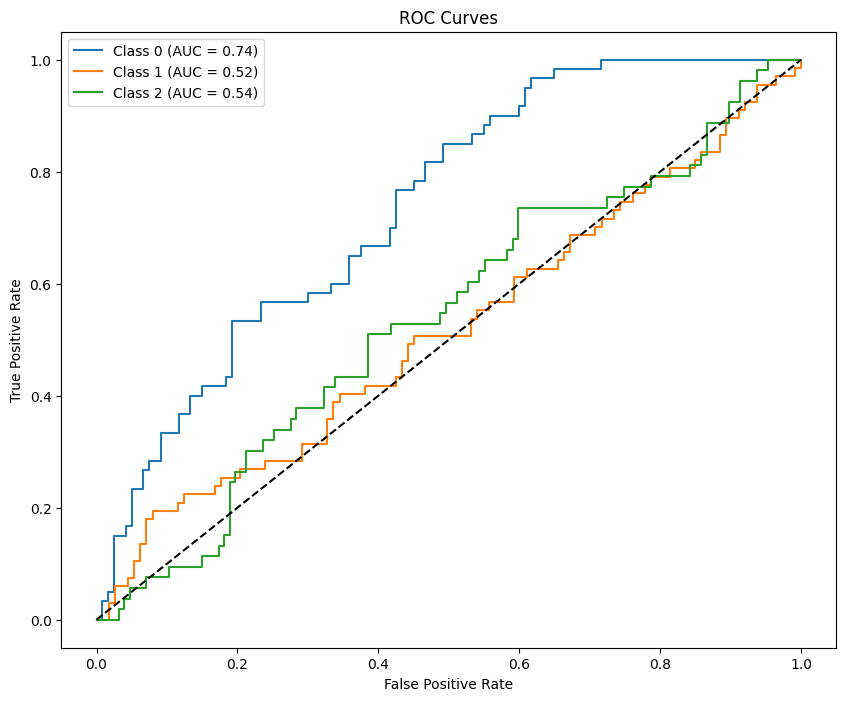


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.37      0.97      0.53        67
           2       0.00      0.00      0.00        53

    accuracy                           0.36       180
   macro avg       0.12      0.32      0.18       180
weighted avg       0.14      0.36      0.20       180


Overall Accuracy: 0.3611


In [86]:
def evaluate_model(model, X_test, y_test):
    """
    Comprehensive model evaluation
    """
    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    report = classification_report(y_test, y_pred_classes)
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    for i in range(3):
        fpr, tpr, _ = roc_curve(y_test == i, y_pred[:, i])
        auc = roc_auc_score(y_test == i, y_pred[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.show()
    
    # Print metrics
    print("\nClassification Report:")
    print(report)
    print(f"\nOverall Accuracy: {accuracy:.4f}")

# Use the evaluation function
evaluate_model(model, X_test, y_test)

Cross validation

In [87]:
from sklearn.model_selection import KFold

def cross_validate_model(X, y, n_splits=5):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        print(f"\nFold {fold + 1}/{n_splits}")
        
        # Split data
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Create and train model
        model = create_model()  # Your model creation function
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=50,
            callbacks=callbacks,
            verbose=1
        )
        
        # Evaluate
        score = model.evaluate(X_val, y_val, verbose=0)
        scores.append(score[1])  # Append accuracy
        
    print(f"\nCross-validation scores: {scores}")
    print(f"Mean accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")